In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Herramientas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency #cramer's v matrix

import warnings
warnings.filterwarnings('ignore')

## Cargamos el data set

In [29]:
from google.colab import files
uploaded = files.upload()
print("agrarius-lepiota.data")

Saving agaricus-lepiota.data to agaricus-lepiota (2).data
agrarius-lepiota.data


In [30]:

columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring",
    "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number",
    "ring-type", "spore-print-color", "population", "habitat"
]

url = "agaricus-lepiota.data"
df = pd.read_csv(url, names=columns)
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


##Análisis de Calidad de Datos
Revisaremos valores nulos y si existen columnas que no aportan información (columnas constantes).

In [31]:
print("Valores nulos por columna:\n", df.isnull().sum().sum())
print("\nValores únicos por característica:")
print(df.nunique())


df.drop('veil-type', axis=1, inplace=True)
print("\nColumna 'veil-type' eliminada por ser constante.")
df.info()

Valores nulos por columna:
 0

Valores únicos por característica:
class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

Columna 'veil-type' eliminada por ser constante.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtyp

##Preprocesamiento de Datos
Los modelos de Machine Learning requieren números, no letras. Aquí convertiremos nuestras variables categóricas.

Manejo de Valores Faltantes
En este dataset, la columna stalk-root tiene valores representados por ?. Los trataremos como una categoría adicional ('unknown').

In [32]:
# Reemplazar '?' por 'unknown'
df['stalk-root'] = df['stalk-root'].replace('?', 'unknown')

##Codificación (One-Hot Encoding)Para las características ($X$), usaremos One-Hot Encoding para evitar dar una jerarquía falsa a las categorías. Para el objetivo ($y$), usaremos Label Encoding.

In [33]:

X = df.drop('class', axis=1)
y = df['class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_encoded = pd.get_dummies(X)

print(f"Columnas tras One-Hot Encoding: {X_encoded.shape[1]}")

Columnas tras One-Hot Encoding: 116


##Análisis Exploratorio de Datos (EDA)
Visualicemos cómo se distribuyen las clases y algunas variables clave.

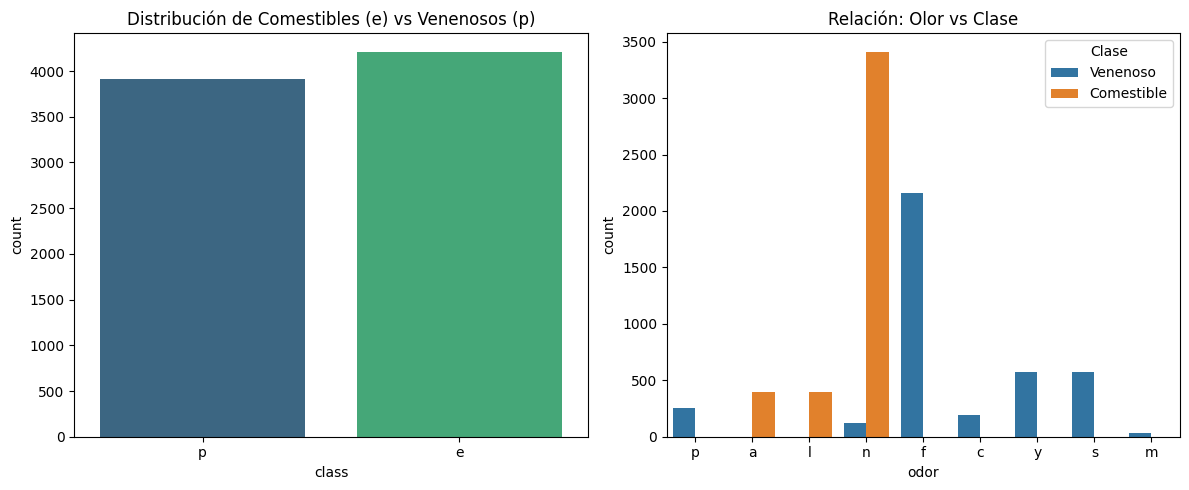

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

sns.countplot(x=y, palette='viridis')
plt.title('Distribución de Comestibles (e) vs Venenosos (p)')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='odor', hue='class')
plt.title('Relación: Olor vs Clase')
plt.legend(title='Clase', labels=['Venenoso', 'Comestible'])

plt.tight_layout()
plt.show()

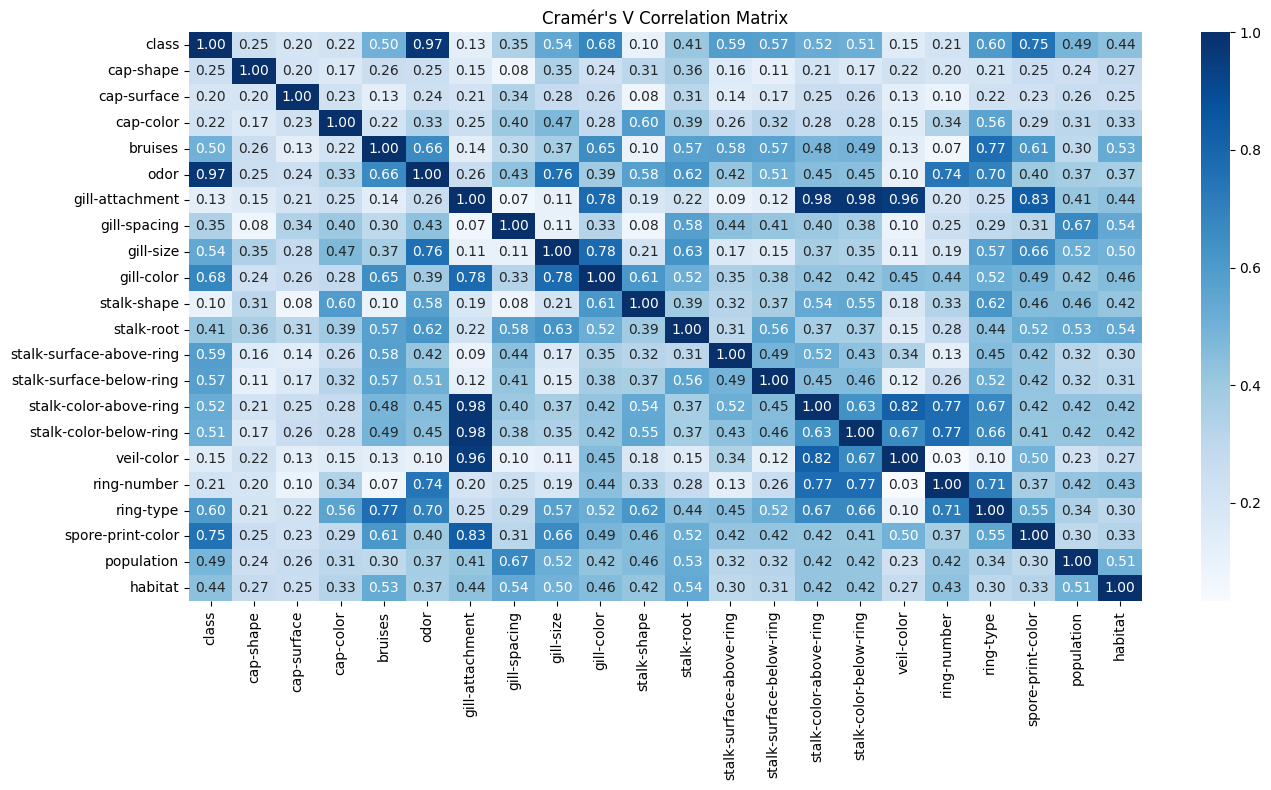

In [47]:
#Cramer's V function
def cramers_v(x, y): #correlation between two columns
    crosstab = pd.crosstab(x, y) #frequency table between two columns (see bivariable analysis)
    chi2 = chi2_contingency(crosstab)[0] #calculate chi-squared
    n = len(x) #rows
    k = min(crosstab.shape) - 1 #number of min categories in the two columns minus one
    return np.sqrt(chi2 / (n * k)) #Cramer's V formula: sqrt(chi2 / (n * k)) (result between 0 and 1))

#Cramer's V matrix
cols = df.columns
matrix = pd.DataFrame(index=cols, columns=cols, dtype=float) #empty table

for col1 in cols: #it iterates through all combinations
    for col2 in cols:
        matrix.loc[col1, col2] = cramers_v(df[col1], df[col2]) #values for the empty table

plt.figure(figsize=(14, 8))
sns.heatmap(matrix.astype(float), annot=True, fmt='.2f', cmap='Blues') #annot=True to show values, fmt='.2f' two decimals
plt.title("Cramér's V Correlation Matrix")
plt.tight_layout()
plt.show()

###Interpretación: El olor es un gran predictor en este dataset; ciertos olores (como el de almendra 'a') son casi exclusivos de hongos comestibles.

##Reducción de Dimensionalidad (PCA)
Tenemos más de 100 columnas tras la codificación. PCA nos permite condensar esa información en 3 ejes principales para poder visualizar los datos en un espacio 3D.

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['class'] = y.values

print(f"Varianza explicada por los 3 componentes: {pca.explained_variance_ratio_.sum():.2%}")

Varianza explicada por los 3 componentes: 24.22%


##Clustering con K-Means
Intentaremos agrupar los hongos sin decirle al modelo cuáles son venenosos.

Método del Codo (Elbow Method)
Determinamos cuántos grupos (clusters) son ideales.

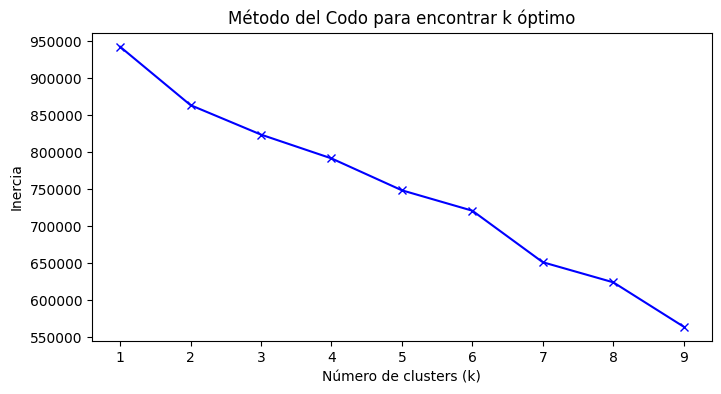

In [36]:
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para encontrar k óptimo')
plt.show()

##Entrenamiento de K-Means y Visualización 3DUsaremos $k=2$ o $k=3$ para ver cómo se agrupan. Visualizaremos el resultado usando el código de Plotly solicitado.

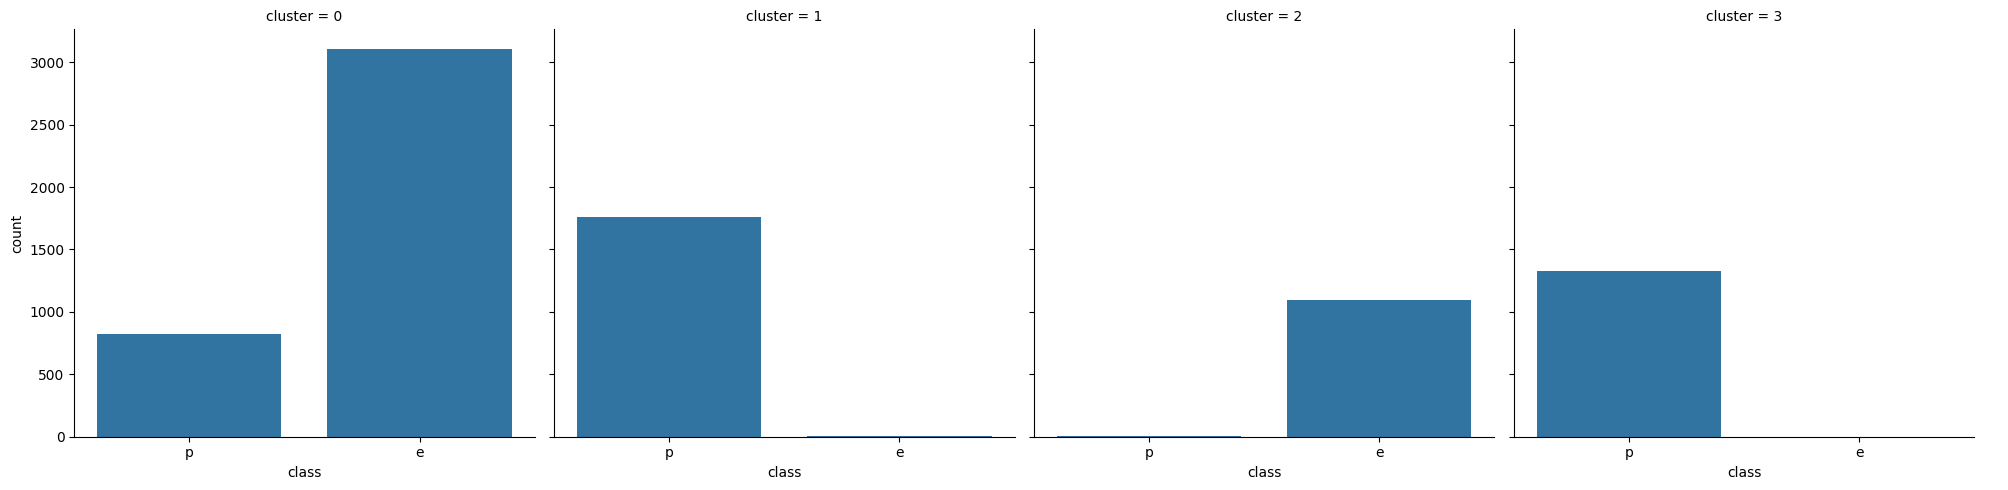

In [40]:
# Aprender Kmeans con el valor de K obtenido.
#n_clusters is the optimal k value obtained from the elbow method.
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_encoded)

# Preparar el catplot.
df_clusters = pd.DataFrame({
    'cluster': clusters,
    'class': y.values
})

# Pintar.
ax = sns.catplot(col='cluster', x='class', data=df_clusters, kind='count',col_wrap=4)

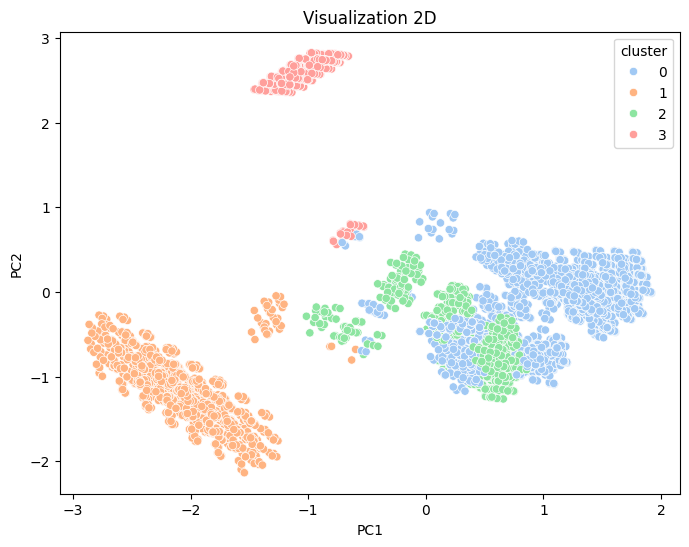

In [42]:
# Train PCA to visualize.
pca_2D = PCA(n_components=4)
X_pca_2D = pca_2D.fit_transform(X_encoded)
# A color per cluster.
df_pca_clusters = pd.DataFrame({
    "PC1": X_pca_2D[:,0],
    "PC2": X_pca_2D[:,1],
    "PC3": X_pca_2D[:,2],
    "PC4": X_pca_2D[:,3],
    "cluster": clusters
})

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca_clusters, x="PC1", y="PC2", hue="cluster", palette="pastel")
plt.title("Visualization 2D")
plt.show()

In [41]:

kmeans = KMeans(n_clusters=4, random_state=42)
df_pca['cluster'] = kmeans.fit_predict(X_scaled).astype(str)


fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',
    color='cluster',
    title="Segmentación en 3 Clusters (K-Means) sobre PCA",
    color_discrete_sequence=px.colors.qualitative.Safe,
    opacity=0.7,
    hover_data=['class'] # Para ver la clase real al pasar el mouse
)
fig.update_traces(marker=dict(size=2))
fig.show()

##Clasificación Supervisada (Random Forest)
Ahora entrenaremos un modelo para predecir si un hongo es peligroso.

Entrenamiento con Datos Originales

--- Rendimiento Random Forest (Features Completas) ---
Accuracy: 1.0000

Matriz de Confusión:


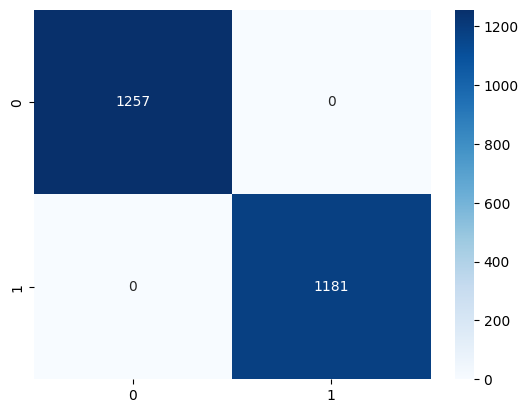


Informe de Clasificación:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1257
           p       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [38]:
# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluación
print("--- Rendimiento Random Forest (Features Completas) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nMatriz de Confusión:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

###Comparación: ¿Qué pasa si usamos solo los 3 componentes del PCA?

In [39]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, y_encoded, test_size=0.3, random_state=42)

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = rf_pca.predict(X_test_pca)

print(f"Accuracy usando solo PCA (3 componentes): {accuracy_score(y_test_pca, y_pred_pca):.4f}")

Accuracy usando solo PCA (3 componentes): 0.9791


###7. Conclusiones y Explicaciones
PCA: Logramos reducir más de 100 dimensiones a solo 3, manteniendo una parte significativa de la varianza. En el gráfico 3D, se observa que los puntos de diferentes clusters tienden a agruparse en regiones específicas, lo que indica que las características físicas sí discriminan bien los tipos de hongos.

K-Means: El algoritmo agrupó los datos basándose puramente en similitudes físicas. Al comparar los clusters con la etiqueta class (comestible/venenoso), vemos una alta correlación, lo que valida que la morfología del hongo está ligada a su toxicidad.

Random Forest: Obtuvimos una precisión cercana o igual al 100%. Esto es común en este dataset porque variables como el "olor" son determinantes casi perfectos. Al usar PCA, la precisión baja ligeramente porque perdemos algo de información, pero el modelo se vuelve mucho más ligero y rápido de procesar.